In [13]:
print('hello')

hello


In [5]:
#%%
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import requests
import os

# Define project root directory
BASE_DIR = Path.cwd()

# Define model and temp directories
MODEL_PATH = BASE_DIR / "data" / "models" / "yolov8n.pt"
TEMP_DIR = BASE_DIR / "data" / "temp"

# Create temp directory if it doesn't exist
TEMP_DIR.mkdir(parents=True, exist_ok=True)

print(f"Model path: {MODEL_PATH}")
print(f"Temp directory: {TEMP_DIR}")

Model path: d:\Working\fastapi-yolov-detection\notebook\data\models\yolov8n.pt
Temp directory: d:\Working\fastapi-yolov-detection\notebook\data\temp


In [7]:
#%%
# Check if model exists
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Load the model
model = YOLO(str(MODEL_PATH))
print("YOLOv8 model loaded successfully!")

YOLOv8 model loaded successfully!


In [8]:
#%%
# Option 1: Download a sample image (e.g., a dog)
SAMPLE_IMAGE_URL = "https://ultralytics.com/images/zidane.jpg"  # Sample image with people (you can replace with animal image)
SAMPLE_IMAGE_PATH = TEMP_DIR / "sample_image.jpg"

# Download image
response = requests.get(SAMPLE_IMAGE_URL)
if response.status_code == 200:
    with open(SAMPLE_IMAGE_PATH, "wb") as f:
        f.write(response.content)
    print(f"Sample image downloaded to {SAMPLE_IMAGE_PATH}")
else:
    raise Exception("Failed to download sample image")

# Option 2: Use local image (uncomment and set path if you have a local image)
# SAMPLE_IMAGE_PATH = Path("path/to/your/local/image.jpg")

Sample image downloaded to d:\Working\fastapi-yolov-detection\notebook\data\temp\sample_image.jpg


0: 384x640 2 persons, 1 tie, 132.9ms
Speed: 26.1ms preprocess, 132.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


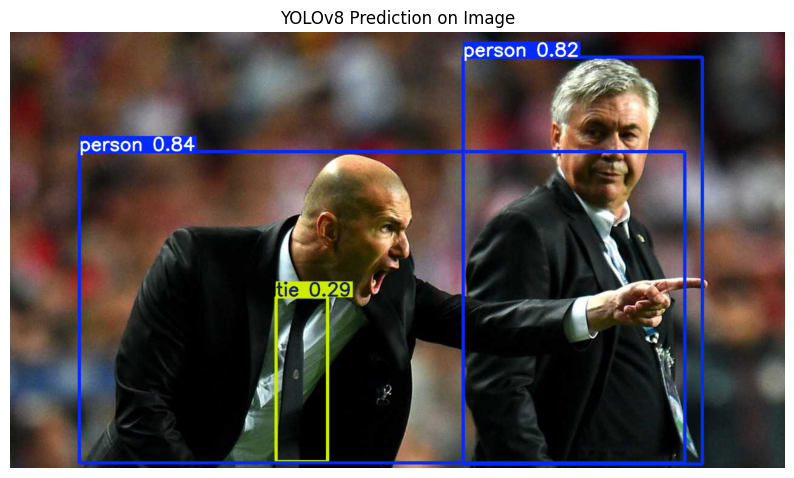

Result saved to d:\Working\fastapi-yolov-detection\notebook\data\temp\output_image.jpg


In [20]:
#%%
# Read image
img = cv2.imread(str(SAMPLE_IMAGE_PATH))
if img is None:
    raise ValueError("Cannot read image")

# Run prediction
results = model(img)

# Plot and display result
annotated_img = results[0].plot()  # Draw bounding boxes and labels
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Display image
plt.figure(figsize=(10, 8))
plt.imshow(annotated_img_rgb)
plt.axis("off")
plt.title("YOLOv8 Prediction on Image")
plt.show()

# Save result
OUTPUT_IMAGE_PATH = TEMP_DIR / "output_image.jpg"
cv2.imwrite(str(OUTPUT_IMAGE_PATH), annotated_img)
print(f"Result saved to {OUTPUT_IMAGE_PATH}")

In [12]:
SAMPLE_VIDEO_PATH = TEMP_DIR / "dog.mp4"

In [44]:
#%%
from ultralytics import YOLO

# Check if model exists
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Initialize predictor (use YoloPredictor if available, else direct YOLO)
try:
    predictor = YoloPredictor()
except NameError:
    predictor = YOLO(str(MODEL_PATH))
print("YOLOv8 model loaded successfully!")

Task exception was never retrieved
future: <Task finished name='Task-64' coro=<Server.serve() done, defined at d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\uvicorn\server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\uvicorn\main.py", line 580, in run
    server.run()
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\uvicorn\server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "C:\Users\dothe\AppData\Roaming\uv\python\cpython-3.10.1

YOLOv8 model loaded successfully!


In [46]:
import nest_asyncio
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import StreamingResponse, JSONResponse
import uvicorn
import io
import cv2
import numpy as np
import tempfile
import os
from pathlib import Path
from ultralytics import YOLO

# Apply nest_asyncio for notebook compatibility
nest_asyncio.apply()

# Initialize FastAPI app
app = FastAPI(
    title="Animal Detection API",
    description="API for detecting animals in images and videos using YOLOv8",
    version="0.1.0"
)

# Define paths
BASE_DIR = Path.cwd()
MODEL_PATH = BASE_DIR / "data" / "models" / "yolov8n.pt"
TEMP_DIR = BASE_DIR / "data" / "temp"

# Create temp directory
TEMP_DIR.mkdir(parents=True, exist_ok=True)

# Load YOLO model
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")
model = YOLO(str(MODEL_PATH))

@app.post("/predict/image")
async def predict_image_with_bbox(file: UploadFile = File(...)):
    # Đọc file ảnh
    contents = await file.read()
    nparr = np.frombuffer(contents, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Chạy prediction
    results = model(img)
    
    # Vẽ bounding boxes
    annotated_img = results[0].plot()
    
    # Chuyển ảnh thành bytes để trả về
    is_success, buffer = cv2.imencode(".jpg", annotated_img)
    if not is_success:
        return JSONResponse(content={"error": "Failed to process image"}, status_code=500)
    
    # Trả về ảnh dưới dạng response
    return StreamingResponse(io.BytesIO(buffer.tobytes()), media_type="image/jpeg")

@app.post("/predict/video")
async def predict_video(file: UploadFile = File(...)):
    # Validate file type
    if not file.content_type.startswith("video/"):
        raise HTTPException(status_code=400, detail="File must be a video (mp4, avi, etc.)")
    
    # Save video to temporary file
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".mp4", dir=str(TEMP_DIR))
    try:
        contents = await file.read()
        temp_file.write(contents)
        temp_file.close()
        
        # Open video
        cap = cv2.VideoCapture(temp_file.name)
        if not cap.isOpened():
            raise HTTPException(status_code=400, detail="Cannot read video")
        
        # Process frames (limit to 100 frames)
        frame_count = 0
        max_frames = 100
        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                raise HTTPException(status_code=404, detail="No dogs or cats detected in the first 100 frames")
            
            frame_count += 1
            # Run YOLO prediction
            results = model(frame, classes=[16, 17])  # Limit to dog (16) and cat (17)
            
            # Check for detected objects
            if len(results[0].boxes) > 0:
                annotated_frame = results[0].plot()
                
                # Convert to bytes for response
                is_success, buffer = cv2.imencode(".jpg", annotated_frame)
                if not is_success:
                    raise HTTPException(status_code=500, detail="Failed to process frame")
                
                cap.release()
                return StreamingResponse(io.BytesIO(buffer.tobytes()), media_type="image/jpeg")
        
        cap.release()
        raise HTTPException(status_code=404, detail="No dogs or cats detected in the first 100 frames")
    
    finally:
        # Clean up temporary file
        if temp_file.name and os.path.exists(temp_file.name):
            os.unlink(temp_file.name)

if __name__ == "__main__":
    uvicorn.run(app, host="127.0.0.1", port=8000)

Task exception was never retrieved
future: <Task finished name='Task-79' coro=<Server.serve() done, defined at d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\uvicorn\server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\uvicorn\main.py", line 580, in run
    server.run()
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\uvicorn\server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "d:\Working\fastapi-yolov-detection\.venv\lib\site-packages\nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "C:\Users\dothe\AppData\Roaming\uv\python\cpython-3.10.1

INFO:     Started server process [8696]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:20918 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:20918 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:20918 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:20918 - "GET /openapi.json HTTP/1.1" 200 OK

0: 384x640 2 persons, 1 tie, 142.3ms
Speed: 37.0ms preprocess, 142.3ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
INFO:     127.0.0.1:20919 - "POST /predict/image HTTP/1.1" 200 OK

0: 384x640 1 dog, 289.9ms
Speed: 10.9ms preprocess, 289.9ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)
INFO:     127.0.0.1:20944 - "POST /predict/video HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [8696]
